# spinal_test2.ipynb
Second test of the delegational learning rule in the context of the spinal cord project.
The task is the same as in spinal_test1.ipynb, but the am_pm_oscillator model is used.

Let $S_F, S_P, S_{P-F}, M_C$ denote the regions of the cortical model, and $s_F, s_P, s_{P-F}, m_C$ denote their current activities.
Assume that each unit $u_j$ in $M_C$ is associated with a vector $\bar{v}_j$, and that the ouput of the plant is $p = \sum_j u_j \bar{v}_j$. We also set $s_F = p$. The rule should be such that $p \approx s_P$.

The plant $P$ can be implemented as a population of linear units.
If the connection matrix from $M_C$ to $P$ is called $W$, then
$\bar{v}_j = (W_{1,j}, W_{2,j}, ..., W_{n,j})^T \equiv W_{:,j}$. 

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
# Create the neuronal populations
N = 8 # size of each population
des_pat = np.zeros(N) # desired pattern in SP
des_pat[np.arange(0,N,2)] = 1. # a one every other entry

net_params = {'min_delay' : 0.01,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.5,
             'tau' : 0.05 }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda x: None }
SPF1_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 1.5,
              'init_val' : 0.3,
              'tau_fast': 0.08,
              'tau_mid': 0.5,
              'tau_slow' : 2.,
              'tau' : 0.05 }
SPF2_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 1.5,
              'init_val' : 0.3,
              'tau_fast': 0.08,
              'tau_mid': 0.5,
              'tau_slow' : 2.,
              'tau' : 0.05,}
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }
init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
M_params = {'type' : unit_types.am_pm_oscillator,
            'tau_u' : 0.1,
            'tau_c' : 1.,
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [r*init_base for r in np.random.random(N)],
            'multidim' : True,
            'omega' : 5.,
            'F' : 'input_sum',
            'tau_fast': 0.1,
            'tau_mid' : 0.4,
            'tau_slow' : 2.,
            'delay' : 0.11 }

net = network(net_params)
SF = net.create(N, SF_params)
SP = net.create(N, SP_params)
SPF1 = net.create(N, SPF1_params)
SPF2 = net.create(N, SPF2_params)
P = net.create(N, P_params)
ME = net.create(N, M_params)
MI = net.create(N, M_params)

# set the pattern in SP
def make_fun(idx):
    return lambda t: des_pat[idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# Create the connections. See note on "detecting layer distances" in cortex wiki
SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF1__ME_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__ME_conn = SPF1__ME_conn
SPF1__MI_conn = SPF1__ME_conn
SPF2__MI_conn = SPF1__ME_conn
SPF1__ME_syn = {'type' : synapse_types.diff_hebbsnorm,
                'lrate': .5,
                'post_delay': 10,
                'inp_ports': 0,
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
SPF2__ME_syn = SPF1__ME_syn
SPF1__MI_syn = SPF1__ME_syn
SPF2__MI_syn = SPF1__ME_syn
# Specify the connection matrix from ME/MI to P
W = 5.*np.eye(N)
ME__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
ME__P_syn = {'type': synapse_types.static,
             'init_w' : W.flatten() }
MI__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
MI__P_syn = {'type': synapse_types.static,
             'init_w' : -W.flatten() }
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }
# mutual inhibition in M
ME__ME_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
ME__ME_syn = {'type' : synapse_types.bcm,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : 0.01 }
ME__MI_conn = ME__ME_conn
ME__MI_syn = {'type' : synapse_types.static,
              'inp_ports': 1,
              'init_w' : -0.15 }
MI__ME_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
MI__ME_syn = {'type' : synapse_types.corr_inh,
              'lrate' : 0.5,
              'des_act' : 0.3,
              'inp_ports': 1,
              'init_w' : -.2}
MI__MI_conn = MI__ME_conn
MI__MI_syn = MI__ME_syn = {'type' : synapse_types.corr_inh,
              'lrate' : 0.1,
              'des_act' : 0.5,
              'inp_ports': 1,
              'init_w' : -.1 }

net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
net.connect(ME, P, ME__P_conn, ME__P_syn)
net.connect(MI, P, MI__P_conn, MI__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
net.connect(MI, ME, MI__ME_conn, MI__ME_syn)

In [3]:
start_time = time.time()
times, data, _  = net.run(10.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 21.97507119178772 seconds


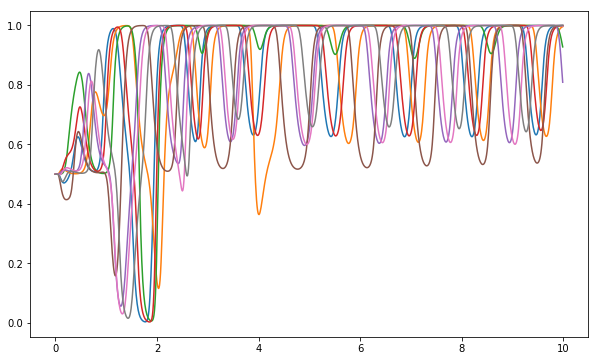

[0.9999306  0.99611092 0.92801048 0.99956735 0.80914853 0.99978738
 0.99800652 0.99999857]


In [4]:
# SF
SF_fig = plt.figure(figsize=(10,6))
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.show()
print(SF_data[:,-1])

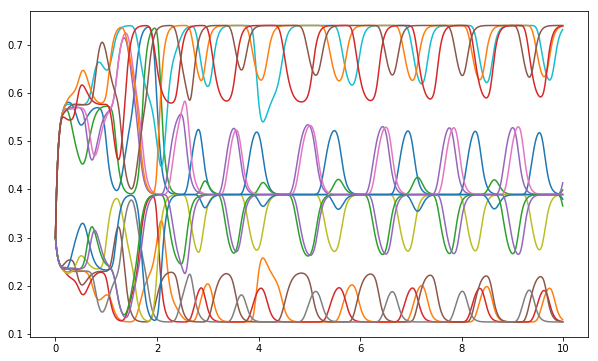

[0.38969356 0.12948806 0.3990742  0.12532666 0.41379439 0.12499399
 0.38940616 0.12455713 0.38903492 0.73232673 0.37977023 0.73943828
 0.36572526 0.74001677 0.38931538 0.74076833]


In [5]:
# SPF
SPF_fig = plt.figure(figsize=(10,6))
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.show()
print(SPF_data[:,-1])

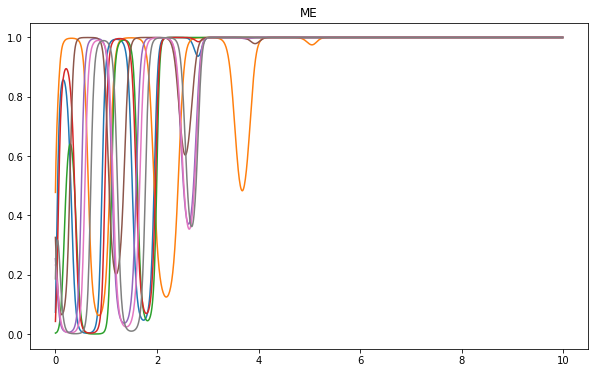

[1. 1. 1. 1. 1. 1. 1. 1.]


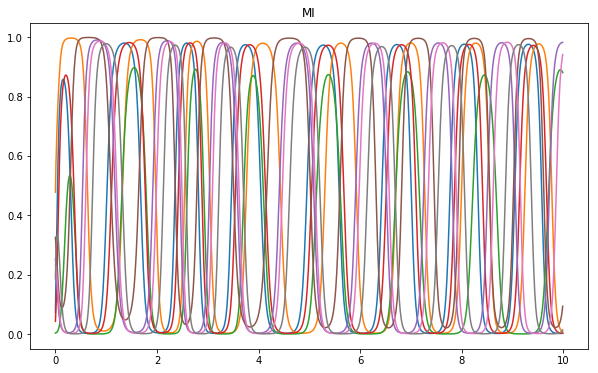

[0.00258107 0.00727667 0.88068092 0.00258496 0.98257346 0.09363821
 0.94154248 0.01373204]


In [6]:
# M
ME_fig = plt.figure(figsize=(10,6))
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.title('ME')
plt.show()
print(ME_data[:,-1])

MI_fig = plt.figure(figsize=(10,6))
MI_data = np.array(data[MI])
plt.plot(times, MI_data.transpose())
plt.title('MI')
plt.show()
print(MI_data[:,-1])


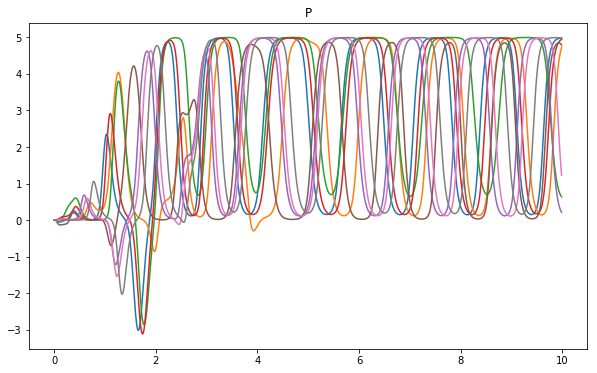

[4.98322598 4.72350359 0.63855228 4.94524775 0.21224376 4.7891858
 1.22787974 4.97608581]


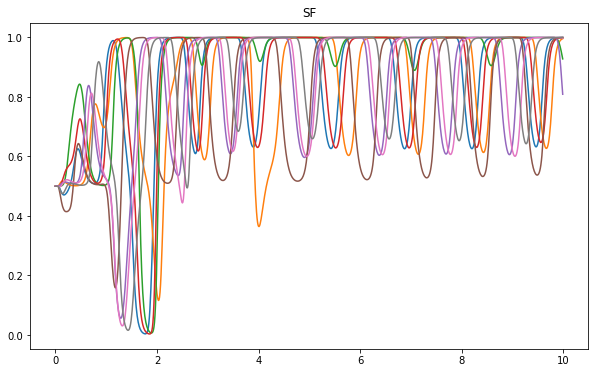

[0.9999306  0.99611092 0.92801048 0.99956735 0.80914853 0.99978738
 0.99800652 0.99999857]


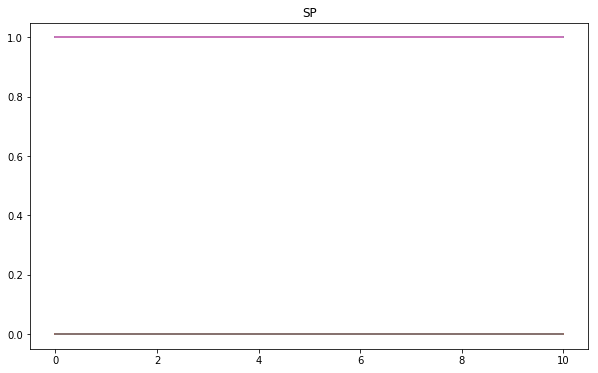

[1. 0. 1. 0. 1. 0. 1. 0.]


In [7]:
# P
P_fig = plt.figure(figsize=(10,6))
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=(10,6))
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.title('SF')
plt.show()
print(SF_data[:,-1])

# SP
SP_fig = plt.figure(figsize=(10,6))
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.title('SP')
plt.show()
print(SP_data[:,-1])

In [8]:
for idx, syn in enumerate(net.syns[ME[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> ME, w=0.081620
1) SPF1 (17) --> ME, w=0.060335
2) SPF1 (18) --> ME, w=0.049472
3) SPF1 (19) --> ME, w=0.043612
4) SPF1 (20) --> ME, w=0.069845
5) SPF1 (21) --> ME, w=0.055524
6) SPF1 (22) --> ME, w=0.078623
7) SPF1 (23) --> ME, w=0.071987
8) SPF2 (24) --> ME, w=0.090719
9) SPF2 (25) --> ME, w=0.108070
10) SPF2 (26) --> ME, w=0.060226
11) SPF2 (27) --> ME, w=0.092639
12) SPF2 (28) --> ME, w=0.047562
13) SPF2 (29) --> ME, w=0.079286
14) SPF2 (30) --> ME, w=0.074739
15) SPF2 (31) --> ME, w=0.065470
16) ME (41) --> ME, w=0.349090
17) ME (42) --> ME, w=0.339831
18) ME (43) --> ME, w=0.409042
19) ME (44) --> ME, w=0.318561
20) ME (45) --> ME, w=0.345587
21) ME (46) --> ME, w=0.321923
22) ME (47) --> ME, w=0.349535
23) MI (48) --> ME, w=-0.272596
24) MI (49) --> ME, w=-0.250658
25) MI (50) --> ME, w=-0.200341
26) MI (51) --> ME, w=-0.266702
27) MI (52) --> ME, w=-0.268108
28) MI (53) --> ME, w=-0.304566
29) MI (54) --> ME, w=-0.263158
30) MI (55) --> ME, w=-0.258679


In [9]:
for idx, syn in enumerate(net.syns[MI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> MI, w=0.100525
1) SPF1 (17) --> MI, w=0.050542
2) SPF1 (18) --> MI, w=0.056261
3) SPF1 (19) --> MI, w=0.058378
4) SPF1 (20) --> MI, w=0.060990
5) SPF1 (21) --> MI, w=0.042274
6) SPF1 (22) --> MI, w=0.114571
7) SPF1 (23) --> MI, w=0.109524
8) SPF2 (24) --> MI, w=0.031845
9) SPF2 (25) --> MI, w=0.096852
10) SPF2 (26) --> MI, w=0.076916
11) SPF2 (27) --> MI, w=0.078567
12) SPF2 (28) --> MI, w=0.068375
13) SPF2 (29) --> MI, w=0.075989
14) SPF2 (30) --> MI, w=0.077922
15) SPF2 (31) --> MI, w=0.062901
16) MI (48) --> MI, w=-0.192743
17) MI (49) --> MI, w=-0.070590
18) MI (50) --> MI, w=-0.105846
19) MI (51) --> MI, w=-0.170218
20) MI (52) --> MI, w=0.000000
21) MI (53) --> MI, w=-0.013600
22) MI (54) --> MI, w=-0.029767
23) MI (55) --> MI, w=-0.110509
24) ME (40) --> MI, w=-0.150000
25) ME (41) --> MI, w=-0.150000
26) ME (42) --> MI, w=-0.150000
27) ME (43) --> MI, w=-0.150000
28) ME (44) --> MI, w=-0.150000
29) ME (45) --> MI, w=-0.150000
30) ME (46) --> MI, w=-0.150000
31)

# PART 2
Open loop test of the `am_pm_oscillator` model.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
net_params = {'min_delay' : 0.01,
              'min_buff_size' : 10 }
osc_params = {'type' : unit_types.am_pm_oscillator,
            'tau_u' : 1.,
            'tau_c' : 1.,
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [[0.2, 0.2, 0., 0.1], [0.5, 0.5, 0., 0.8]],
            'multidim' : True,
            'omega' : 1.,
            'F' : 'zero',
            'tau_fast': 0.1,
            'tau_mid' : 0.4,
            'tau_slow' : 2.,
            'delay' : 0.11 }
src_params = {'type' : unit_types.source,
              'init_val' : 1.,
              'function' : lambda t: np.sin(10.*t) }
net = network(net_params)
osc = net.create(2, osc_params)
src = net.create(1, src_params)
src__osc_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
src__osc_syn = {'type' : synapse_types.static,
                'inp_ports': 0,
                'init_w' : 1. }
net.connect(src, osc, src__osc_conn, src__osc_syn)

In [3]:
start_time = time.time()
#times, data, _  = net.flat_run(20.)
times, data, _  = net.run(10.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 0.41196274757385254 seconds


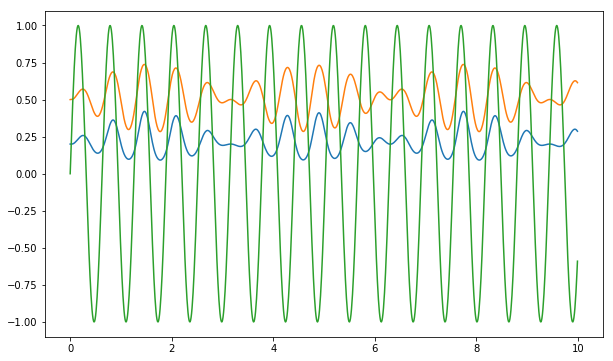

In [4]:
fig = plt.figure(figsize=(10,6))
plt.plot(times, data.transpose())
#plt.plot(times, np.sqrt(2.)*np.sin(2.*times), 'r')
plt.show()

In [5]:
print(net.units[0].buffer[:,-1])
print(net.units[1].buffer[:,-1])

[-4.97440801e-02  2.20763682e-01  1.00000000e+02  5.34213278e-01]
[  0.24246048   0.51299787 100.           0.53421344]


In [24]:
1. + 0.6068*np.sin(50.)

0.840790938772456